In [1]:
import gym
from gym import spaces
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import talib
from collections import deque
import random
import datetime

# 環境の作成
env = gym.make('CartPole-v0')

# ネットワークの定義
model = torch.nn.Sequential(
    torch.nn.Linear(env.observation_space.shape[0], 24),
    torch.nn.ReLU(),
    torch.nn.Linear(24, env.action_space.n)
)

# Set the device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Users/tek/dev/python/mlbot-bybit/venv/lib/python3.11/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(


In [9]:
def feature_engineering(df):
    open = df['open'].values
    high = df['high'].values
    low = df['low'].values
    close = df['close'].values
    # volume = df['volume'].values
    hilo = (high + low) / 2

    df['RSI8'] = talib.RSI(close, timeperiod=8) # default = 14
    df['RSI14'] = talib.RSI(close, timeperiod=14)
    df['RSI_ST'] = talib.RSI(close)/close
    df['RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df['MACD'], _, _ = talib.MACD(close)
    df['MACD_ST'], _, _ = talib.MACD(close)/close
    df['ATR'] = talib.ATR(high, low, close)
    
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['+DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['-DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    
    df['SMA15'] = talib.SMA(close, timeperiod=15) # 15分足
    df['SMA300'] = talib.SMA(close, timeperiod=300) # 15分足20MA
    
    df['BB_UPPER'], df['BB_MIDDLE'], df['BB_LOWER'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] = (df['BB_UPPER'] - hilo) / close
    df['BBANDS_middleband'] = (df['BB_MIDDLE'] - hilo) / close
    df['BBANDS_lowerband'] = (df['BB_LOWER'] - hilo) / close

    df['STOCH_K'], df['STOCH_D'] = talib.STOCH(high, low, close)/close
    df['MON'] = talib.MOM(close, timeperiod=5)

    df['pinbar'] = pinbar(df)
    df['RCI'] = df['close'].rolling(9).apply(calc_rank_correlation)

    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')

    return df

def pinbar(df):
    body = np.abs(df['close'] - df['open'])
    upper_wick = df['high'] - np.max(df[['open', 'close']], axis=1)
    lower_wick = np.min(df[['open', 'close']], axis=1) - df['low']
    total_length = df['high'] - df['low']
    
    # 上向きのピンバー（ロングサイン）:下ワックが本体の3倍以上、上ワックが全体の長さの20~30%以内
    is_bullish_pinbar = (lower_wick >= 3 * body) & (upper_wick <= total_length * 0.3)
    
    # 下向きのピンバー（ショートサイン）:上ワックが本体の3倍以上、下ワックが全体の長さの20~30%以内
    is_bearish_pinbar = (upper_wick >= 3 * body) & (lower_wick <= total_length * 0.3)
    
    # 上向きピンバー = 1、下向きピンバー = 2、ピンバーでない = 0
    return np.where(is_bullish_pinbar, 1, np.where(is_bearish_pinbar, 2, 0))

def calc_rank_correlation(series):
    n = len(series)
    ranks = series.rank()
    sum_diffs_squared = sum((ranks - np.arange(n) - 1) ** 2)
    return 1 - 6 * sum_diffs_squared / (n * (n ** 2 - 1))

def log_transform_feature(X):
    X[X <= 0] = np.finfo(float).eps
    return np.log(X)

In [40]:
class TradingEnvMatsui(gym.Env):
    def __init__(self, df, gamma=0.95, f=0.5, eta=0.1):
        super(TradingEnvMatsui, self).__init__()

        self.df = df
        self.reward_range = (-np.inf, np.inf)
        self.action_space = spaces.Discrete(3)  # 0: Do nothing, 1: Buy, 2: Sell
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.df.shape[1] + 4,))

        self.cash = 1000000  # Initial cash position
        self.holdings = 0  # Initial asset holdings
        self.history = []  # Initialize history
        self.episode_rewards = [] 

        self.gamma = gamma  # Discount factor
        self.f = f  # Investment ratio
        self.eta = eta  # Learning rate for f
        self.purchase_price = 0  # To track purchase price for delayed reward calculation
        self.max_reward = 0

    def step(self, action):
        assert self.action_space.contains(action)

        current_price = self.df.iloc[self.current_step]['close']
        
        # Check if done before incrementing the step
        done = self.current_step == len(self.df) - 1
        if done:
            return self._get_observation(), 0, done, {}  # return zero reward

        self.current_step += 1

        old_total_asset = self.cash + self.holdings * self.purchase_price

        reward = 0
        penalty = self.max_reward * 0.1 

        # Action logic
        if action == 1:  # Buy
            if self.cash >= current_price:
                self.holdings += 1
                self.cash -= current_price
                self.purchase_price = current_price
            else:
                reward -= penalty
        elif action == 2:  # Sell
            if self.holdings > 0:
                self.holdings -= 1
                self.cash += current_price
            else:
                reward -= penalty

        new_total_asset = self.cash + self.holdings * current_price

        # Calculate reward as increase in asset value
        if old_total_asset > 0:
            # Use return instead of asset increase
            reward = (new_total_asset - old_total_asset) / old_total_asset
            # Apply the compound return and discount
            reward = (1 + reward * self.f) ** self.gamma
        else:
            reward = 0

        # Update max_reward
        self.max_reward = max(self.max_reward, reward)

        # Update f using online gradient method
        self.f += self.eta * reward / (1 + reward * self.f)

        # Record the history
        self.history.append({
            "step": self.current_step,
            "cash": self.cash,
            "action": action,
            "total_asset": self.cash + self.holdings * current_price
        })

        self.episode_rewards.append(reward)

        return self._get_observation(), reward, done, {}

    def reset(self):
        self.cash = 1000000
        self.holdings = 0
        # self.history = []
        # self.episode_rewards = []
        self.current_step = 0
        self.purchase_price = 0 
        self.f = 0.5  # Reset the investment ratio
        return self._get_observation()
    
    def _get_observation(self):
        total_asset = self.cash + self.holdings * self.purchase_price
        if total_asset > 0:
            cash_ratio = self.cash / total_asset
            holdings_ratio = self.holdings * self.purchase_price / total_asset
        else:
            cash_ratio = 0
            holdings_ratio = 0
        return np.append(self.df.iloc[self.current_step], [self.holdings, self.cash, cash_ratio, holdings_ratio])
           
    def plot_history(self, action_size):
        df_history = pd.DataFrame(self.history)
        df_history.set_index('step', inplace=True)

        fig, ax = plt.subplots(2, 2, figsize=[16, 10])

        # Total Asset over time
        ax[0][0].plot(df_history['total_asset'], label='Total Asset', linestyle='-')
        ax[0][0].set_title('Total Asset over Time')
        ax[0][0].legend(loc='upper left')
        ax[0][0].set_ylim([df_history['total_asset'].min() * 0.95, df_history['total_asset'].max() * 1.05])

        # Action over time
        ax[0][1].plot(df_history['action'], label='Action over time', linestyle='-')
        ax[0][1].set_title('Action over Time')
        ax[0][1].legend(loc='upper left')
        ax[0][1].set_yticks(range(action_size))

        # Cumulative reward plot
        ax[1][0].plot(np.cumsum(self.episode_rewards), label='Cumulative Reward', linestyle='-')
        ax[1][0].set_title('Cumulative Reward per Episode')
        ax[1][0].legend(loc='upper left')
        ax[0][1].set_yticks(range(action_size)) 

        # Learning curve plot
        ax[1][1].plot([np.mean(self.episode_rewards[i-100:i]) if i >= 100 else np.mean(self.episode_rewards[:i]) for i in range(1, len(self.episode_rewards)+1)], label='Learning Curve (Reward per 100 episodes)')
        ax[1][1].set_title('Learning Curve')
        ax[1][1].legend(loc='upper left')

        plt.tight_layout()
        plt.show()

    def plot_stock_price(self):
        fig, ax = plt.subplots(figsize=[16, 4])
        ax.plot(self.df.index, self.df['close'], label='Close Price')
        ax.set_title('Stock Price')
        ax.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

QNetworkクラスは、状態を入力とし、行動の各可能な結果についての予測確率分布を出力するディープニューラルネットワークです。
このネットワークは、DQNアルゴリズムのバリエーションであるCategorical DQN (C51) を実装するために使用されます。

特に以下の点を注意しています：

forward関数では、入力状態はフル接続層（fc1, fc2, fc3）を通じて伝播されます。これらの層はReLU活性化関数を用いて非線形性を導入しています。

ネットワークの出力は、ソフトマックス関数を用いて正規化され、すべての可能な結果にわたる確率分布を表現します。

このネットワークは出力として確率分布を持つため、損失関数として負の対数尤度（または交差エントロピー）を用いることが一般的です。これにより、ネットワークは真の報酬分布をよりよく近似するように学習します。

In [41]:
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, atom_size, support, v_min, v_max):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size * atom_size)

        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.delta_z = (self.v_max - self.v_min) / (self.atom_size - 1)
        self.action_size = action_size
        self.support = support

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return torch.softmax(x.view(-1, self.action_size, self.atom_size), dim=2) * self.support

In [42]:
class Agent:
    def __init__(self, env, state_size, action_size, atom_size=51, gamma=0.99, lr=0.9):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.atom_size = atom_size
        self.v_min = -10
        self.v_max = 10
        self.support = torch.linspace(self.v_min, self.v_max, self.atom_size).to(device)
        self.rewards_history = []
        self.actions_history = []

        # Initialize Q-Network and target network
        self.q_network = QNetwork(state_size, action_size, atom_size, self.support, self.v_min, self.v_max).to(device)
        self.target_network = QNetwork(state_size, action_size, atom_size, self.support, self.v_min, self.v_max).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()
        # delta_zは、DQNにおけるDistributional DQNの一部となる確率分布の離散化のための間隔
        self.delta_z = (self.v_max - self.v_min) / (self.atom_size - 1)

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.gamma = gamma

        # epsilon-greedy method
        self.epsilon_min = 0.01
        self.epsilon_max = 1.0
        self.epsilon_decay = 0.995

        # Initialize experience replay memory
        self.memory = deque(maxlen=2000)
        self.batch_size = 64

    # 確率的に行動を選択するε-グリーディー法と、ネットワークによるQ値予測を用いた行動選択を行う
    def get_action(self, state, episode):
        # Decrease epsilon over time
        epsilon = max(self.epsilon_min, self.epsilon_max - self.epsilon_decay * episode)
        
        if np.random.rand() <= epsilon:
            return random.randrange(self.action_size)
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = (self.q_network(state) * self.support).sum(dim=2)

        return np.argmax(act_values.cpu().data.numpy())

    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        # Sample a minibatch from memory
        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states).float().to(device)
        actions = torch.tensor(actions).long().unsqueeze(1).to(device)
        rewards = torch.tensor(rewards).float().unsqueeze(1).to(device)
        next_states = torch.tensor(next_states).float().to(device)
        dones = torch.tensor(dones).float().unsqueeze(1).to(device)

        # Compute Q(s_t, a)
        q_dist = self.q_network(states)
        q_dist = q_dist.gather(2, actions.unsqueeze(2).expand(-1, -1, self.atom_size))

        # Compute distributional Bellman update
        with torch.no_grad():
            next_action = (self.q_network(next_states) * self.support).sum(2).max(1)[1]
            next_dist = self.target_network(next_states)[torch.arange(self.batch_size), next_action]
            t_z = rewards + (1 - dones) * self.gamma * self.support.unsqueeze(0)
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / self.delta_z
            l = b.floor().long()
            u = b.ceil().long()
            d_m_l = (u.float() + (l == u).float() - b) * next_dist
            d_m_u = (b - l.float()) * next_dist
        m = states.new_zeros(self.batch_size, self.atom_size)
        m.scatter_add_(1, l, d_m_l)
        m.scatter_add_(1, u, d_m_u)

        # Update Q_Network
        self.q_network.train()
        self.optimizer.zero_grad()
        loss = -(m * q_dist.log()).sum(1).mean()
        loss.backward()
        self.optimizer.step()

        # Update target network
        self.update_target_network()

    def update_target_network(self, tau=0.05):
        for target_param, param in zip(self.target_network.parameters(), self.q_network.parameters()):
            target_param.data.copy_(tau*param.data + (1.0-tau)*target_param.data)

    def learn(self, current_episode, total_episodes):
        state = self.env.reset()
        state = np.reshape(state, [1, self.state_size])
        total_reward = 0
        episode_length = 1000
        for time in range(episode_length):
            action = self.get_action(state, current_episode)
            self.actions_history.append(action)
            next_state, reward, done, _ = self.env.step(action)
            next_state = np.reshape(next_state, [1, self.state_size])
            self.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            self.rewards_history.append(total_reward)
            if done:
                print("Episode: {}/{}, Score: {}" 
                        .format(current_episode, total_episodes, total_reward))
                break
            if len(self.memory) > self.batch_size:
                self.replay()
        return total_reward
    
    def save_model(self):
        # Get current date and time
        now = datetime.datetime.now()

        # Format datetime object to string
        now_str = now.strftime('%Y%m%d_%H%M%S')

        # Save model weights with datetime in filename
        torch.save(self.q_network.state_dict(), '../model/model_weights_' + now_str + '.pth')

    def load_model(self, model_path):
        self.q_network.load_state_dict(torch.load(model_path))
        self.q_network.eval()

    def perform_action(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        with torch.no_grad():
            act_values = (self.q_network(state) * self.support).sum(dim=2)
        return np.argmax(act_values.cpu().data.numpy())

元のget_action関数では、エージェントはQネットワークから予測される行動価値に基づいて常に最適な行動を選択しています。この動作は完全に活用（exploitation）に偏っており、ランダムな行動（探索）はまったく行われません。

提案した新しいget_action関数では、確率epsilonでランダムな行動を選択し、残りの確率で最適な行動を選択します。これにより、エージェントは環境を探索することと、学習した知識に基づいて行動を選択することの間でトレードオフを実現します。

また、epsilonはエピソードが進むにつれて減少します。つまり、エージェントは初めのうちは環境をランダムに探索することが多く、経験を積むにつれて学習した知識に基づいて行動を選択することが増えます。

このような探索と活用のバランスは、強化学習の重要な部分であり、エージェントが全体的に最適な戦略を学習するのに役立ちます。

,date,open,high,low,close,volume,RSI8,RSI14,RSI_ST,RSI_LOG,...,BB_MIDDLE,BB_LOWER,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,STOCH_K,STOCH_D,MON,pinbar,RCI
0,1627743660000,41340.58,41347.05,41340.58,41347.05,0.000546,81.519133,70.512204,0.001700,4.255786,...,41455.7850,41292.107043,0.002964,-0.000981,-0.004926,0.002392,0.002263,51.77,0,0.766667
1,1627743720000,41347.05,41347.05,41320.71,41320.71,0.001308,81.519133,70.512204,0.001700,4.255786,...,41455.7850,41292.107043,0.002964,-0.000981,-0.004926,0.002392,0.002263,51.77,0,0.766667
2,1627743780000,41320.71,41320.71,41309.40,41309.40,0.001086,81.519133,70.512204,0.001700,4.255786,...,41455.7850,41292.107043,0.002964,-0.000981,-0.004926,0.002392,0.002263,51.77,0,0.766667
3,1627743840000,41309.40,41314.08,41309.40,41314.08,0.000481,81.519133,70.512204,0.001700,4.255786,...,41455.7850,41292.107043,0.002964,-0.000981,-0.004926,0.002392,0.002263,51.77,0,0.766667
4,1627743900000,41314.08,41327.25,41314.08,41327.25,0.002747,81.519133,70.512204,0.001700,4.255786,...,41455.7850,41292.107043,0.002964,-0.000981,-0.004926,0.002392,0.002263,51.77,0,0.766667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
740795,1672413540000,16508.20,16512.86,16498.28,16508.61,15.606035,93.555720,80.867625,0.004899,4.392814,...,16438.4905,16373.718069,-0.000140,-0.004063,-0.007987,0.004450,0.004824,56.93,1,1.000000
740796,1672413600000,16508.61,16523.98,16504.91,16504.91,18.356253,87.878490,77.945828,0.004723,4.356014,...,16443.0080,16373.139461,-0.000095,-0.004328,-0.008561,0.004024,0.004467,49.90,2,0.950000
740797,1672413660000,16504.91,16513.00,16502.58,16510.18,7.890198,88.968206,79.103896,0.004791,4.370762,...,16448.0415,16374.161458,0.000856,-0.003619,-0.008094,0.003919,0.004130,48.55,0,0.950000
740798,1672413720000,16510.18,16517.09,16499.36,16517.09,9.953238,90.277916,80.546334,0.004877,4.388833,...,16453.5930,16376.547340,0.001357,-0.003308,-0.007972,0.003698,0.003879,22.48,0,0.950000


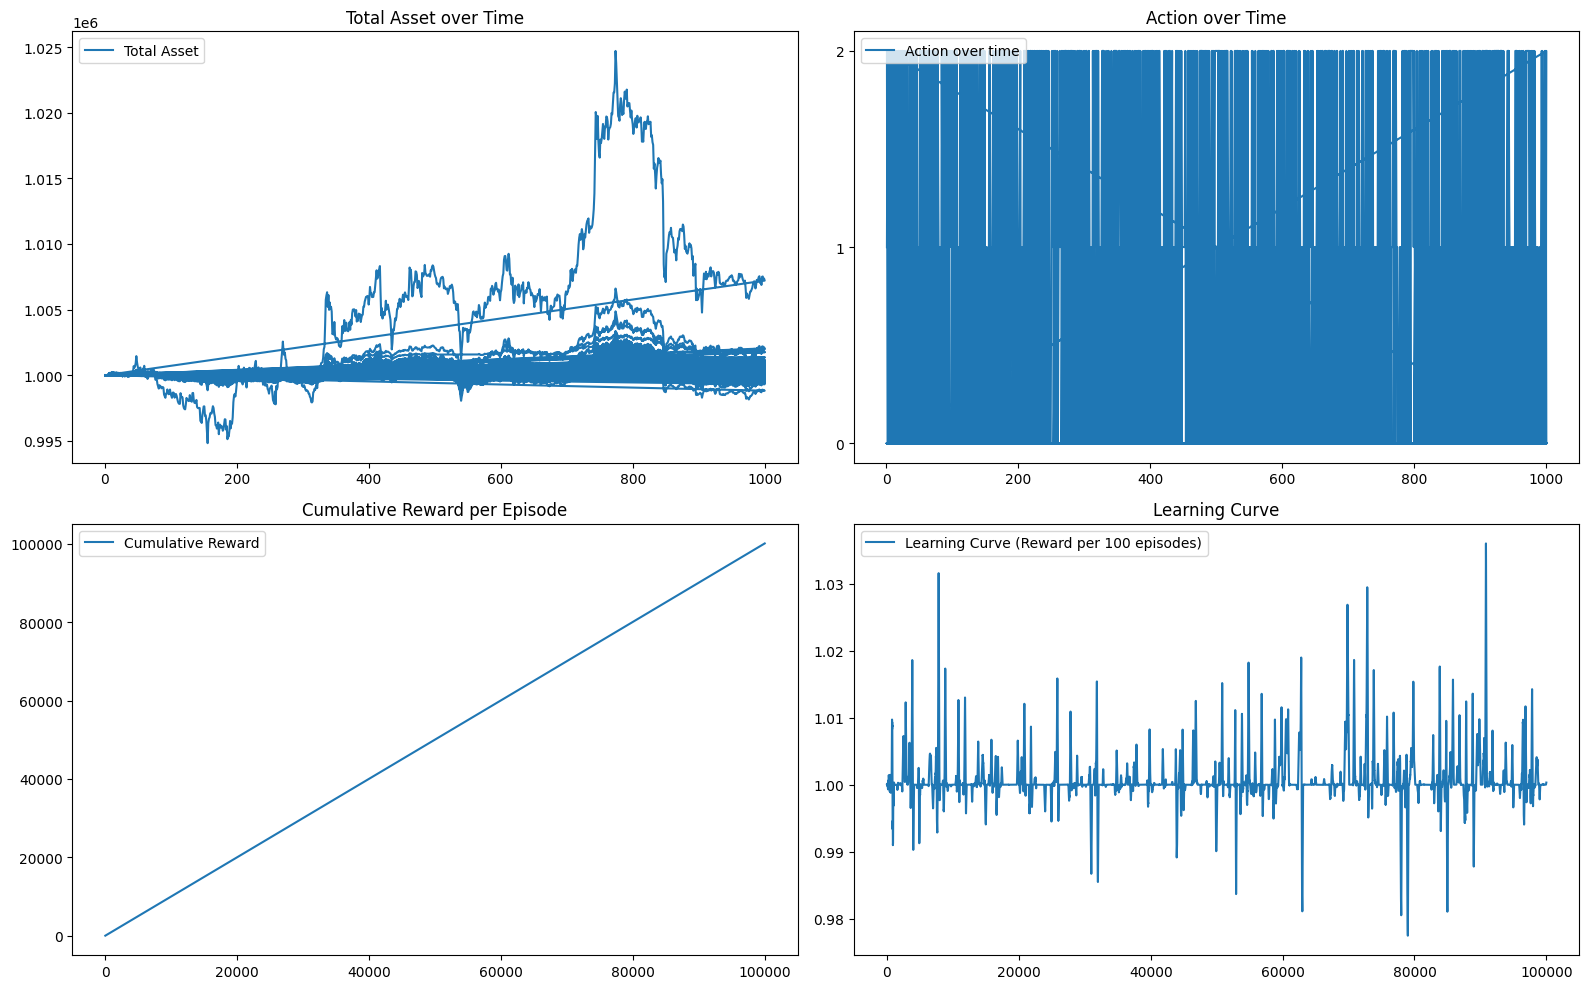

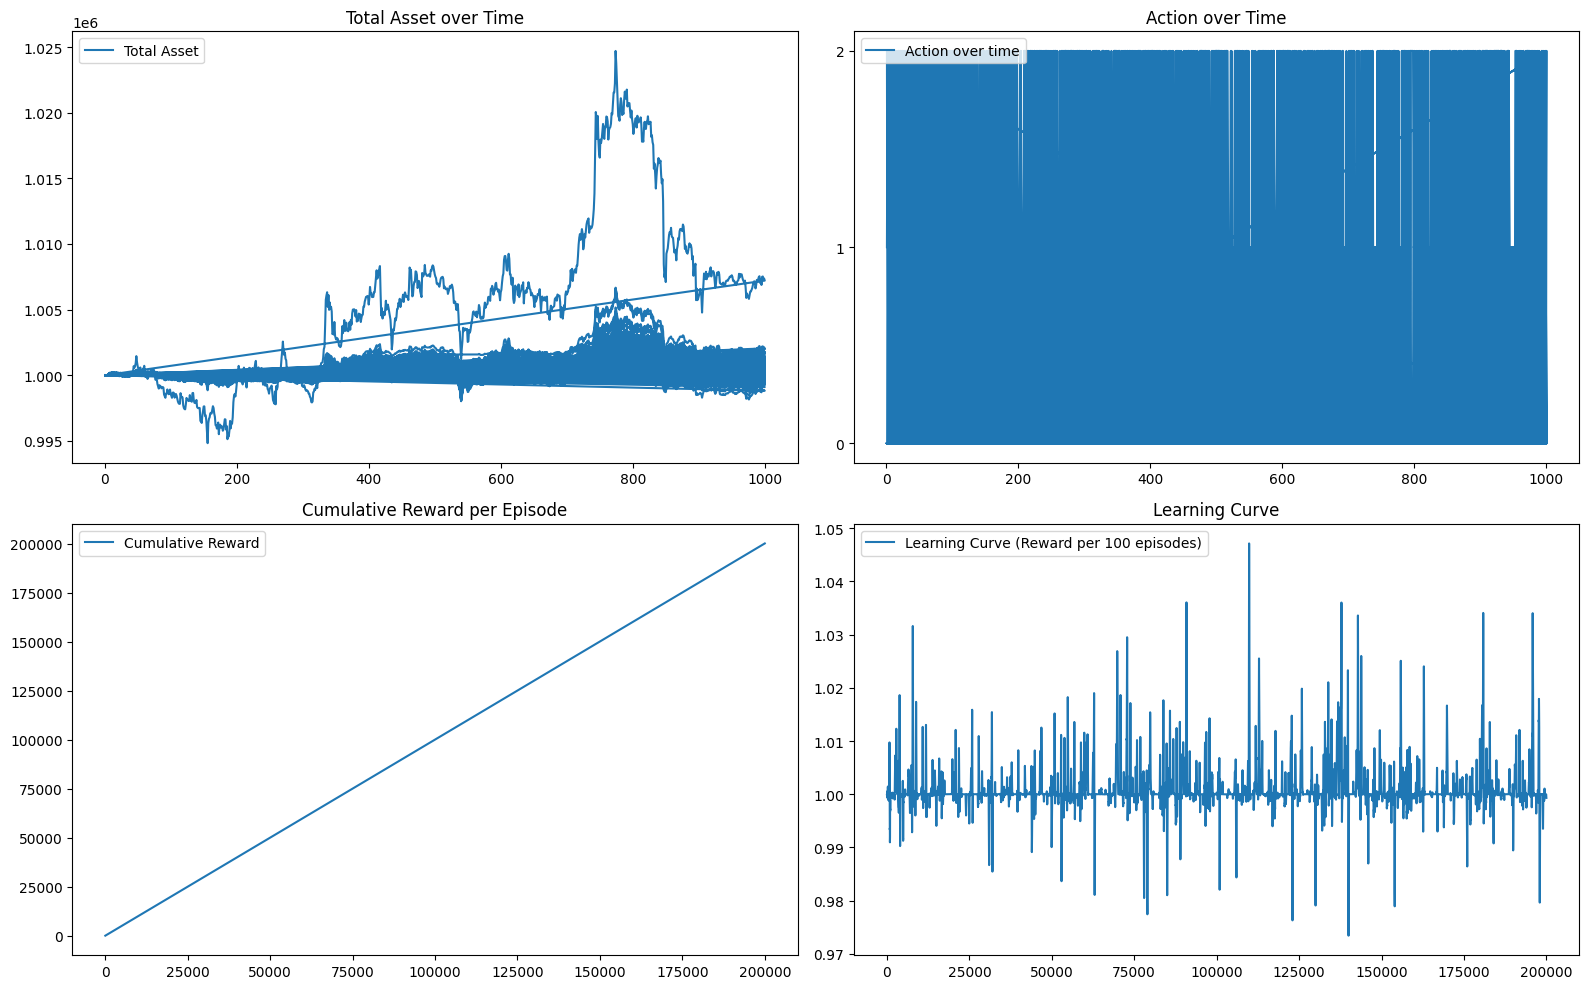

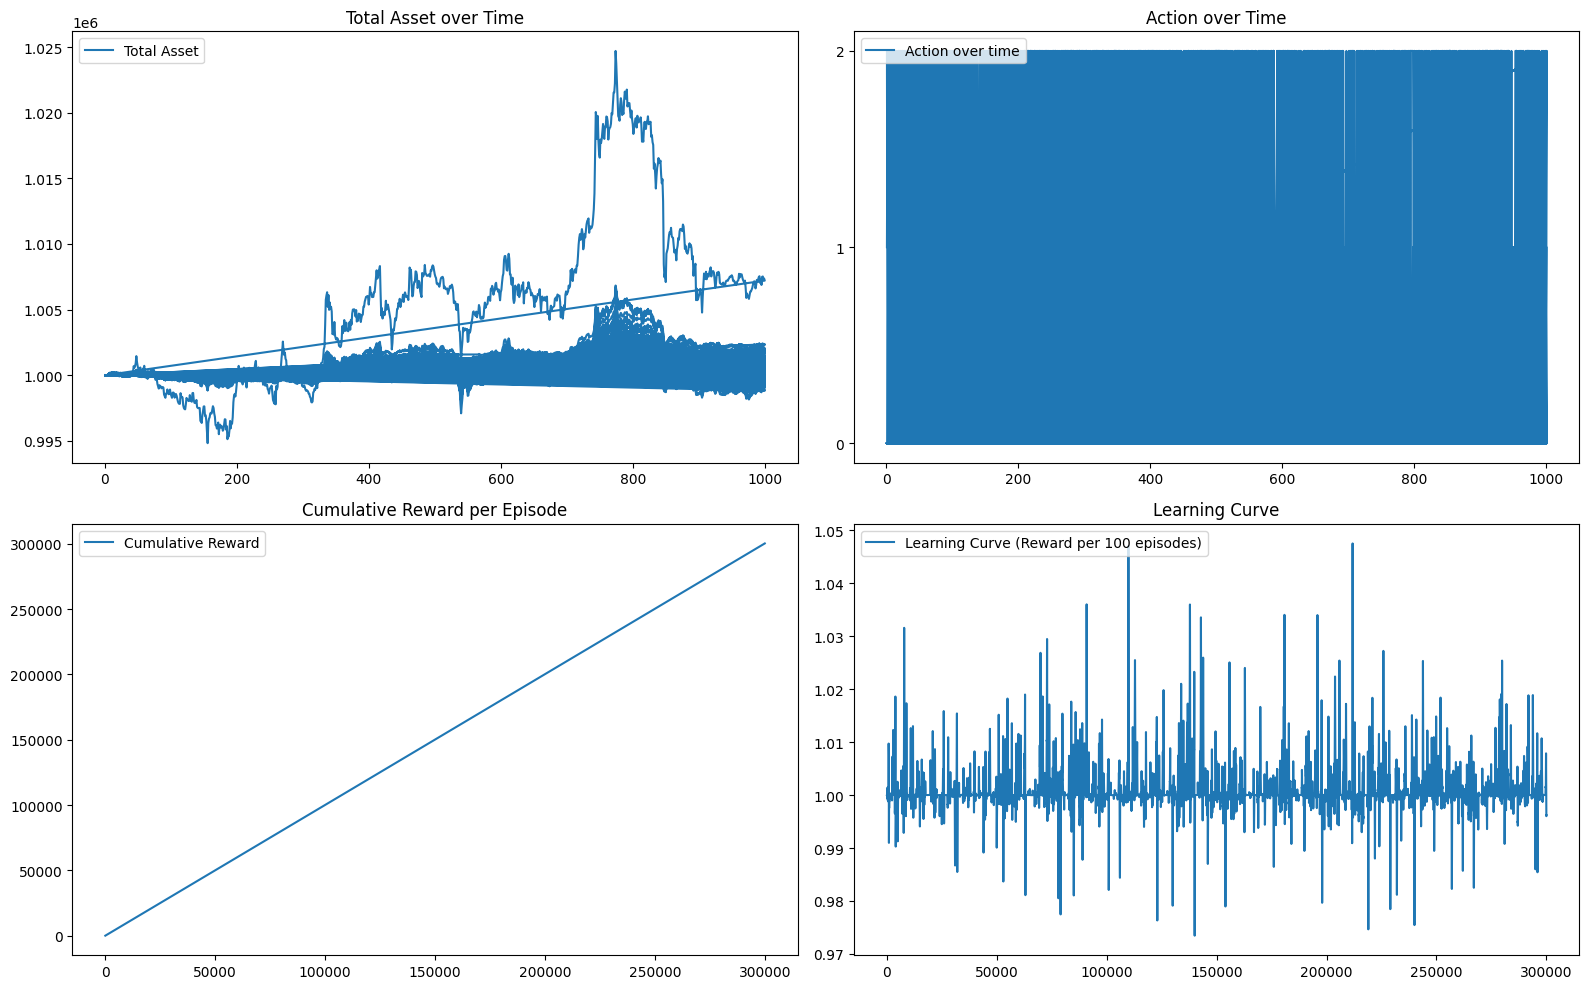

KeyboardInterrupt: 

In [43]:
df = pd.read_csv('../csv/BTCUSDT_1m_20210801_20221231.csv')
df = feature_engineering(df)
display(df)

# Initialize the environment and the agent
env = TradingEnvMatsui(df)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = Agent(env, state_size, action_size)

# Run the main training loop
EPISODES = 1000
for e in range(EPISODES):
    agent.learn(e, EPISODES)
    if (e+1) % 100 == 0:
        env.plot_history(action_size)

# Plot the stock price at the end
env.plot_stock_price()

In [14]:
agent.save_model()